In [1]:
# Set up

import numpy as np
import pandas as pd

# Data management & cleaning
import json # to load json files
import gc # to delete files from cache
import os #to get file names in directory
import random #for random sampling of files
import pickle #to save lists
import glob
#pip install pyarrow

# Analysis
import spacy # for named entity recognition

import en_core_web_sm #https://github.com/explosion/spaCy/issues/4577
import country_converter as coco #https://pypi.org/project/country-converter/ #pip install country_converter --upgrade
from sklearn.preprocessing import MultiLabelBinarizer
import re #regular expressions
import pycountry # for regular expresison country names
import wbgapi as wb


# Visualization
import matplotlib.pyplot as plt


path="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv/"

save_file="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/country_classifications.csv"

In [2]:
#read in the data
all_files = glob.glob(os.path.join(path, "*.csv"))

df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


df_pd=df_pd[['paper_id','title','abstract','year','doi', 'venue', 'journal','mag_field_of_study']]

C:\Users\wb469649\AppData\Local\Temp\ipykernel_6900\1380426063.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\wb469649\AppData\Local\Temp\ipykernel_6900\1380426063.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\wb469649\AppData\Local\Temp\ipykernel_6900\1380426063.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [3]:
# Show example text
%time
df_pd["abstract"][100000]

CPU times: total: 0 ns
Wall time: 0 ns


"Abstract This article examines United Nations Educational, Scientific, and Cultural Organisation (UNESCO) cultural heritage policies and Chinese state-directed tourism policies in contemporary Tibet. It begins with a brief overview of the tourism industry in Tibet, and moves to a discussion of UNESCO's focus on the preservation of world cultural sites in the name of universal values, noting how this aids state claims to authority over culture as a tool in state-building in places such as Tibet and Indonesia. The article then examines the effects state tourism policies have had on specific Tibetan sites, based on field visits to Lhasa and Shigatse in 2001 and 2002 and Xiahe (Gansu Province) in 2004. In a word, the Potala Palace, as a world cultural heritage and a place of religious activities, has drawn the attention of the world. With the deepening of the reform, opening and modermization drive and along with the implementation of the going-west strategy, the Potala Palace has become 

In [4]:
#extract GPE
paper_index = list(df_pd.index) # this ist just a list of the index/CoreIDs
nlp = en_core_web_sm.load() #load model; https://github.com/explosion/spaCy/issues/4577
#nlp = spacy.load("en_core_web_sm") # load model

In [5]:
%%time

# a problem here is that the extracted GPEs are saved as lists within the dataframe and I think 
# that takes up a lot of memory
# but in the next step we actually need them as list, so converting it to strings is not really a solution

# https://stackoverflow.com/questions/44395656/applying-spacy-parser-to-pandas-dataframe-w-multiprocessing
#https://spacy.io/api/language#pipe

places = []
counter = 0
manual_batch_size = 10000

for doc in nlp.pipe(df_pd.loc[paper_index,'abstract'].astype('unicode').values,
                    batch_size=20,
                    #n_threads=8,
                    n_process = -1,
                    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]): 
    
    if len(doc.ents) != 0:
        places.append([ent.as_doc() for ent in doc.ents if ent.label_ in ['GPE']])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        places.append([])
    
    # Creating ONE list of all the extracted GPEs took up too much memory, leading the kernel to die.
    # Therfore, I am saving the results from every 1000 publications directly to the dataframe,
    # and then clear the list.
    if (len(places)%manual_batch_size == 0):
        df_pd.loc[paper_index[(counter*manual_batch_size):(manual_batch_size*(counter + 1))],'places'] = places
        counter += 1
        print(counter/(df_pd.shape[0]/manual_batch_size)) # print out progress
        del places
        gc.collect()
        places = []

Standardize country names

In [ ]:
%%capture
# use country converter to standarize country names
countries = coco.convert(names=df_pd.loc[paper_index,"places"], to='ISO3', src ="regex", not_found = "nf")
df_pd.loc[paper_index,'countries'] = countries

In [ ]:
df_pd[['paper_id','title','abstract', 'places', 'countries']].head(25)

,paper_id,title,abstract,places,countries
0,159350887,No. 8 Cultural and other relations - Mapping C...,Cultural relations between Central Asian and t...,"[(India), (Japan), (South, Korea), (Iran), (Tu...","[IND, IRN, JPN, KOR, TUR]"
1,159352431,The Ship Owner's Lien on Sub-freights and Pers...,"In the event of default by a head charterer, a...","[(New, Zealand), (Australia), (Canada)]","[AUS, CAN, NZL]"
2,159355456,An update on model Ayush wellness clinic at pr...,The Government of India has presented an expan...,"[(India), (India), (Secretariat), (Unani), (Si...",IND
3,18980463,Adult and larval photoreceptors use different ...,Although development of the adult Drosophila c...,[(Spalt)],nf
4,18981358,Rubber hand illusion induced by touching the f...,Background: Studies in animals and humans indi...,[],nf
5,18982114,Determinants of outcome in critically ill octo...,BACKGROUND ::: The population in the UK is gro...,[(UK)],nf
6,18982341,Coase and Bertrand on Lighthouses,Coase (Journal of Low and Economics 17(2):185-...,[(Bertrand)],nf
7,18982460,A novel automatic regulatory device for contin...,Background:Benign prostatic hyperplasia is a c...,[],nf
8,18982781,The Del1 deposition domain can immobilize 3α-h...,Developing methods that result in targeting of...,[],nf
9,18985891,Global Morbidity and Mortality of Leptospirosi...,"Background ::: ::: Leptospirosis, a spirochaet...",[(Oceania)],nf


#### Get dummies

Unfortunately, the output of country-convert is none conistent. Sometimes the type is list, sometimes str, sometimes none.

In [ ]:
%%time
for i in paper_index: #len(df_pd)
    if type(df_pd.loc[i,'countries']) == str:
        df_pd.at[i,"countries"] = df_pd.loc[i,'countries'].split()

CPU times: total: 5.58 s
Wall time: 6.13 s


In [ ]:
%%time
# Get dummies
#Inspiration: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies 
#Inspiration: https://stackoverflow.com/questions/47209847/is-there-a-method-for-creating-dataframe-of-dummy-variables-from-a-dictionary-of
s = df_pd.loc[paper_index,'countries']
mlb = MultiLabelBinarizer()
df_c = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=paper_index)

#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()


CPU times: total: 1 s
Wall time: 1.02 s


,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,VGB,VIR,VNM,VUT,XKX,YEM,ZAF,ZMB,ZWE,nf
0,159350887,No. 8 Cultural and other relations - Mapping C...,Cultural relations between Central Asian and t...,2018,10.17185/duepublico/47242,NaN,NaN,NaN,"[(India), (Japan), (South, Korea), (Iran), (Tu...","[IND, IRN, JPN, KOR, TUR]",...,0,0,0,0,0,0,0,0,0,0
1,159352431,The Ship Owner's Lien on Sub-freights and Pers...,"In the event of default by a head charterer, a...",2014,NaN,NaN,Australian and New Zealand Maritime Law Journal,NaN,"[(New, Zealand), (Australia), (Canada)]","[AUS, CAN, NZL]",...,0,0,0,0,0,0,0,0,0,0
2,159355456,An update on model Ayush wellness clinic at pr...,The Government of India has presented an expan...,2018,10.15406/ijcam.2018.11.00389,NaN,International Journal of Complementary and Alt...,NaN,"[(India), (India), (Secretariat), (Unani), (Si...",[IND],...,0,0,0,0,0,0,0,0,0,0
3,18980463,Adult and larval photoreceptors use different ...,Although development of the adult Drosophila c...,2007,10.1101/gad.1565407,Genes & development,Genes & development,NaN,[(Spalt)],[nf],...,0,0,0,0,0,0,0,0,0,1
4,18981358,Rubber hand illusion induced by touching the f...,Background: Studies in animals and humans indi...,2014,10.3389/fnhum.2014.00404,Front. Hum. Neurosci.,NaN,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Save data
df_final.reset_index().to_csv(save_file)


In [ ]:
df_s = df_c.sum().to_frame(name = "papers")

# Show 50 countries with highest number of publications
df_s = df_s.sort_values(by = "papers", ascending = False)
df_s.head(50)



,papers
nf,164820
USA,2732
CHN,2271
IND,1346
AUS,1095
JPN,1050
DEU,889
BRA,872
CAN,863
GBR,787


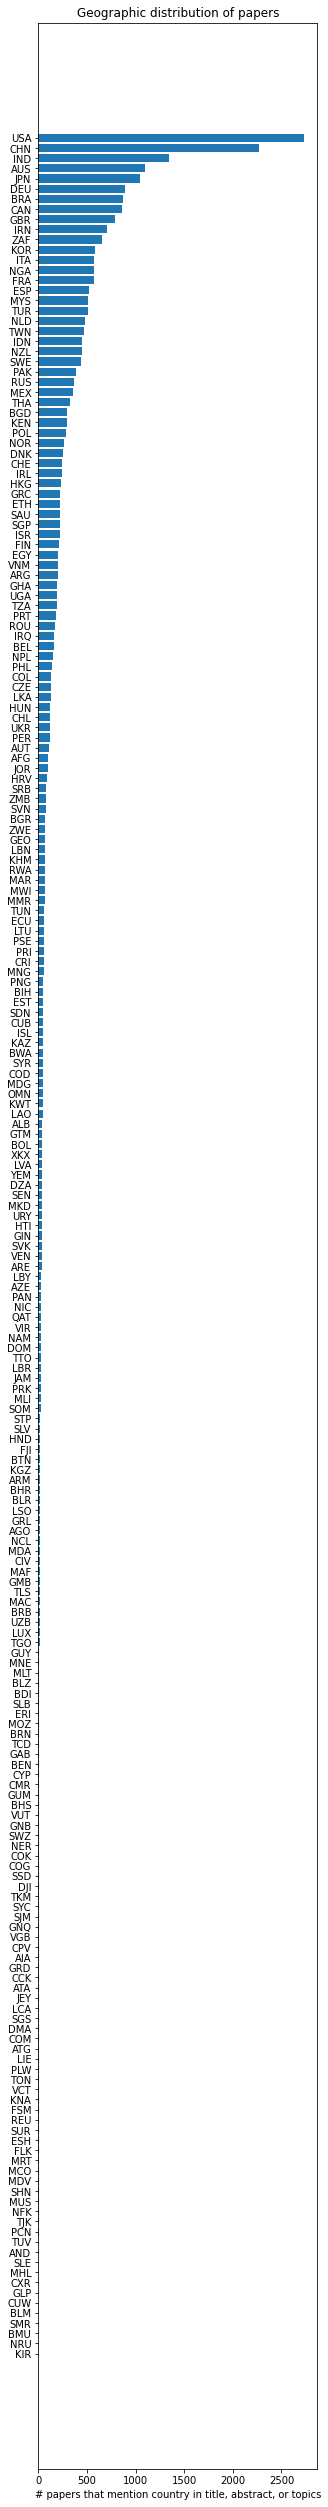

In [ ]:
# Bar graph of countries without NF
fig, ax = plt.subplots(figsize =(5,45))
y_pos = np.arange(df_s[df_s.index[1]:].shape[0])
ax.barh(y_pos,df_s[df_s.index[1]:].papers.values)
ax.set_yticks(y_pos)
ax.set_yticklabels(df_s[df_s.index[1]:].index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# papers that mention country in title, abstract, or topics')
ax.set_title('Geographic distribution of papers')
plt.show()


In [ ]:
#download data from World Bank on population and GDP per capita, PPP (2017 dollars) using API
wdi_df = wb.data.DataFrame(['SP.POP.TOTL','NY.GDP.PCAP.PP.KD','NY.GDP.MKTP.PP.KD'], time=2021, labels=True).reset_index()

#set index to econonies
wdi_df.set_index('economy', inplace=True)

wdi_df.head()

C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\wbgapi\data.py:327: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dummy = pd.Series()    # empty series - never assigned actual values


,Country,NY.GDP.MKTP.PP.KD,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,5.275695e+10,3495.649923,15092171.0
ZMB,Zambia,6.241219e+10,3298.626768,18920657.0
YEM,"Yemen, Rep.",NaN,NaN,30490639.0
PSE,West Bank and Gaza,2.777943e+10,5643.072243,4922749.0
VIR,Virgin Islands (U.S.),NaN,NaN,105870.0


In [ ]:
#merge wdi_df with df_s 
df_merged = pd.concat([df_s, wdi_df], axis=1)


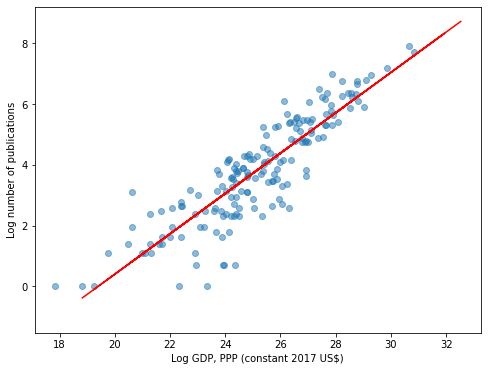

In [ ]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.MKTP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

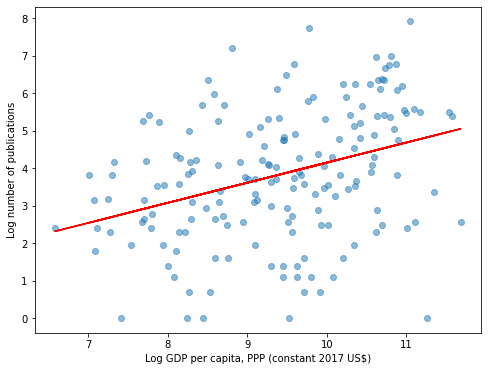

In [ ]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.PCAP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP per capita, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

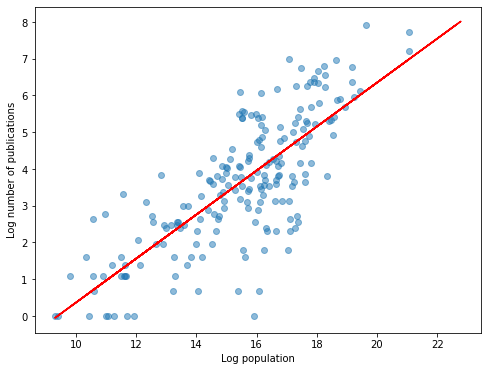

In [ ]:
# Scatter of population and number of publications
x = np.log(df_merged["SP.POP.TOTL"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log population")
plt.ylabel("Log number of publications")
plt.show()

## Classify Papers by Country - Regular Expressions


In [ ]:
# get list of all countries and subdivisions
country_dict = {} 
to_be_removed = ["West", "East", "Center","Centre","North","South",
                 "Western","Eastern","Southern","Northern","Central",
                 "Ouest", "Est", "Sud", "Est", "Nord","Centre-Est","Centre-Sud","Centre-Ouest","Centre-Nord",
                 "Norte", "Este", "Sur", "Oeste",
                 "Has", "Ha", "Male", "Mat", "Delta", "Leon","León","Como","Para","Most","Pool"] #MAT, relevant for subdivisions
for country in pycountry.countries:
    entities = ["\s" + country.name + "[\s,.:]"]
    # THIS CODE IS FOR SUBDIVISIONS: (commented because too slow)
    #for sub_div in pycountry.subdivisions.get(country_code = country.alpha_2):
    #    if sub_div.name not in to_be_removed:
    #    #adding spaces before and allowing for max 1 or zero characters afters (e.g. a comma),
    #    # otherwise segments being picked up
    #        entities.append("\s" + sub_div.name + "[\s,.:]")  
    country_dict[country.alpha_3] = entities

In [ ]:
def check_if_country_or_subdiv_present(df, name_of_text_column, country_code_alpha3):
    df_matrix = pd.DataFrame(index=df.index)
    for entity in country_dict[country_code_alpha3]:
        df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)
    df_matrix["present"] = df_matrix.max(axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df_matrix.sum()) #turn on to analyze sub-div level results
    return df_matrix["present"]
    del df_matrix
    gc.collect()

In [ ]:
%time
for country_code_alpha3 in country_dict.keys():
#for country_code_alpha3 in ["ARG"]:
    column_name = country_code_alpha3 + "_regex"
    df_c[column_name] = check_if_country_or_subdiv_present(df_pd, "abstract", country_code_alpha3)
    # Take the maximum SpaCy and %regex detection
    # print("here with", country_code_alpha3)
    if country_code_alpha3 in df_c.columns: #if we already made a column with spacy, combine (inclusively) the results
        df_c[country_code_alpha3] = df_c[[country_code_alpha3,column_name]].max(axis=1) 
        df_c = df_c.drop(columns = [column_name])
    else:
        df_c[country_code_alpha3] = df_c[column_name]
        df_c = df_c.drop(columns = [column_name]) 

CPU times: total: 0 ns
Wall time: 68.2 µs
\sAruba[\s,.:]    1
present           1
dtype: int64
\sAfghanistan[\s,.:]    107
present                 107
dtype: int64
\sAngola[\s,.:]    15
present            15
dtype: int64
\sAnguilla[\s,.:]    4
present              4
dtype: int64
\sÅland Islands[\s,.:]    0
present                   0
dtype: int64
\sAlbania[\s,.:]    41
present             41
dtype: int64
\sAndorra[\s,.:]    2
present             2
dtype: int64
\sUnited Arab Emirates[\s,.:]    31
present                          31
dtype: int64
\sArgentina[\s,.:]    182
present               182
dtype: int64
\sArmenia[\s,.:]    19
present             19
dtype: int64
\sAmerican Samoa[\s,.:]    1
present                    1
dtype: int64
\sAntarctica[\s,.:]    48
present                48
dtype: int64
\sFrench Southern Territories[\s,.:]    0
present                                 0
dtype: int64
\sAntigua and Barbuda[\s,.:]    1
present                         1
dtype: int64
\sAustralia[

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sCocos (Keeling) Islands[\s,.:]    0
present                             0
dtype: int64
\sSwitzerland[\s,.:]    203
present                 203
dtype: int64
\sChile[\s,.:]    128
present           128
dtype: int64
\sChina[\s,.:]    2446
present           2446
dtype: int64
\sCôte d'Ivoire[\s,.:]    4
present                   4
dtype: int64
\sCameroon[\s,.:]    86
present              86
dtype: int64
\sCongo, The Democratic Republic of the[\s,.:]    0
present                                           0
dtype: int64
\sCongo[\s,.:]    91
present           91
dtype: int64
\sCook Islands[\s,.:]    4
present                  4
dtype: int64
\sColombia[\s,.:]    135
present              135
dtype: int64
\sComoros[\s,.:]    4
present             4
dtype: int64
\sCabo Verde[\s,.:]    3
present                3
dtype: int64
\sCosta Rica[\s,.:]    63
present                63
dtype: int64
\sCuba[\s,.:]    43
present          43
dtype: int64
\sCuraçao[\s,.:]    0
present             0
dtype: int64

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sFalkland Islands (Malvinas)[\s,.:]    0
present                                 0
dtype: int64
\sFrance[\s,.:]    502
present            502
dtype: int64
\sFaroe Islands[\s,.:]    2
present                   2
dtype: int64
\sMicronesia, Federated States of[\s,.:]    0
present                                     0
dtype: int64
\sGabon[\s,.:]    17
present           17
dtype: int64
\sUnited Kingdom[\s,.:]    478
present                    478
dtype: int64
\sGeorgia[\s,.:]    106
present             106
dtype: int64
\sGuernsey[\s,.:]    3
present              3
dtype: int64
\sGhana[\s,.:]    207
present           207
dtype: int64
\sGibraltar[\s,.:]    4
present               4
dtype: int64
\sGuinea[\s,.:]    274
present            274
dtype: int64
\sGuadeloupe[\s,.:]    6
present                6
dtype: int64
\sGambia[\s,.:]    17
present            17
dtype: int64
\sGuinea-Bissau[\s,.:]    4
present                   4
dtype: int64
\sEquatorial Guinea[\s,.:]    4
present               

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sSaint Martin (French part)[\s,.:]    0
present                                0
dtype: int64
\sMorocco[\s,.:]    68
present             68
dtype: int64
\sMonaco[\s,.:]    2
present            2
dtype: int64
\sMoldova, Republic of[\s,.:]    0
present                          0
dtype: int64
\sMadagascar[\s,.:]    43
present                43
dtype: int64
\sMaldives[\s,.:]    7
present              7
dtype: int64
\sMexico[\s,.:]    448
present            448
dtype: int64
\sMarshall Islands[\s,.:]    1
present                      1
dtype: int64
\sNorth Macedonia[\s,.:]    0
present                     0
dtype: int64
\sMali[\s,.:]    33
present          33
dtype: int64
\sMalta[\s,.:]    13
present           13
dtype: int64
\sMyanmar[\s,.:]    56
present             56
dtype: int64
\sMontenegro[\s,.:]    21
present                21
dtype: int64
\sMongolia[\s,.:]    61
present              61
dtype: int64
\sNorthern Mariana Islands[\s,.:]    1
present                              1
dtype:

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sSint Maarten (Dutch part)[\s,.:]    0
present                               0
dtype: int64
\sSeychelles[\s,.:]    6
present                6
dtype: int64
\sSyrian Arab Republic[\s,.:]    1
present                          1
dtype: int64
\sTurks and Caicos Islands[\s,.:]    0
present                              0
dtype: int64
\sChad[\s,.:]    16
present          16
dtype: int64
\sTogo[\s,.:]    8
present          8
dtype: int64
\sThailand[\s,.:]    335
present              335
dtype: int64
\sTajikistan[\s,.:]    7
present                7
dtype: int64
\sTokelau[\s,.:]    1
present             1
dtype: int64
\sTurkmenistan[\s,.:]    5
present                  5
dtype: int64
\sTimor-Leste[\s,.:]    8
present                 8
dtype: int64
\sTonga[\s,.:]    3
present           3
dtype: int64
\sTrinidad and Tobago[\s,.:]    11
present                         11
dtype: int64
\sTunisia[\s,.:]    61
present             61
dtype: int64
\sTurkey[\s,.:]    511
present            511
dtype: int

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sHoly See (Vatican City State)[\s,.:]    0
present                                   0
dtype: int64
\sSaint Vincent and the Grenadines[\s,.:]    2
present                                      2
dtype: int64
\sVenezuela, Bolivarian Republic of[\s,.:]    0
present                                       0
dtype: int64
\sVirgin Islands, British[\s,.:]    0
present                             0
dtype: int64
\sVirgin Islands, U.S.[\s,.:]    0
present                          0
dtype: int64
\sViet Nam[\s,.:]    10
present              10
dtype: int64
\sVanuatu[\s,.:]    8
present             8
dtype: int64
\sWallis and Futuna[\s,.:]    0
present                       0
dtype: int64
\sSamoa[\s,.:]    4
present           4
dtype: int64
\sYemen[\s,.:]    36
present           36
dtype: int64
\sSouth Africa[\s,.:]    647
present                  647
dtype: int64
\sZambia[\s,.:]    77
present            77
dtype: int64
\sZimbabwe[\s,.:]    78
present              78
dtype: int64


In [ ]:
#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()

,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,PRY,PYF,SPM,SXM,TCA,TKL,UMI,VAT,WLF,WSM
0,159350887,No. 8 Cultural and other relations - Mapping C...,Cultural relations between Central Asian and t...,2018,10.17185/duepublico/47242,NaN,NaN,NaN,"[(India), (Japan), (South, Korea), (Iran), (Tu...","[IND, IRN, JPN, KOR, TUR]",...,0,0,0,0,0,0,0,0,0,0
1,159352431,The Ship Owner's Lien on Sub-freights and Pers...,"In the event of default by a head charterer, a...",2014,NaN,NaN,Australian and New Zealand Maritime Law Journal,NaN,"[(New, Zealand), (Australia), (Canada)]","[AUS, CAN, NZL]",...,0,0,0,0,0,0,0,0,0,0
2,159355456,An update on model Ayush wellness clinic at pr...,The Government of India has presented an expan...,2018,10.15406/ijcam.2018.11.00389,NaN,International Journal of Complementary and Alt...,NaN,"[(India), (India), (Secretariat), (Unani), (Si...",[IND],...,0,0,0,0,0,0,0,0,0,0
3,18980463,Adult and larval photoreceptors use different ...,Although development of the adult Drosophila c...,2007,10.1101/gad.1565407,Genes & development,Genes & development,NaN,[(Spalt)],[nf],...,0,0,0,0,0,0,0,0,0,0
4,18981358,Rubber hand illusion induced by touching the f...,Background: Studies in animals and humans indi...,2014,10.3389/fnhum.2014.00404,Front. Hum. Neurosci.,NaN,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Save data
df_final.reset_index().to_csv(save_file)

In [ ]:
df_s = df_c.sum().to_frame(name = "papers")

# Show 50 countries with highest number of publications
df_s = df_s.sort_values(by = "papers", ascending = False)
df_s.head(50)

,papers
nf,164820
USA,3014
CHN,2645
IND,1498
AUS,1228
JPN,1165
CAN,976
BRA,946
DEU,926
GBR,835


In [ ]:
df_merged = pd.concat([df_s, wdi_df], axis=1)


C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\3607638912.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


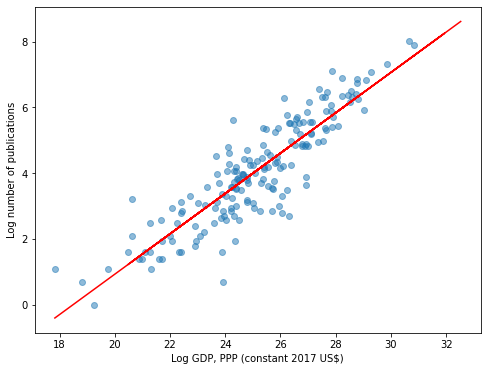

In [ ]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.MKTP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\2490735751.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


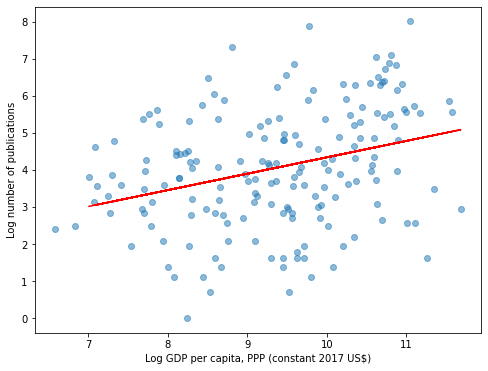

In [ ]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.PCAP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP per capita, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

C:\Users\wb469649\AppData\Local\Temp\ipykernel_14624\704282292.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


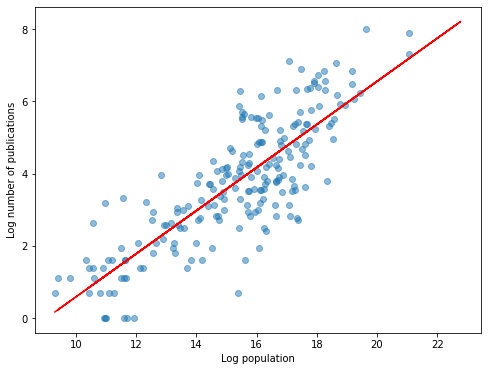

In [ ]:
# Scatter of population and number of publications
x = np.log(df_merged["SP.POP.TOTL"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log population")
plt.ylabel("Log number of publications")
plt.show()